# SYSCALL 


#### Nomes e RA :
Matheus Menecucci  800310

Yago David Pimenta 800273

### Introdução :

Resumidamente uma syscall é o modo de interação entre o user space e o kernel do sistema operacional .

As chamadas das syscalls são definidas através de uma interface em linguagem C. O uso dessa interface em alto nível favorece a portabilidade dos programas, cujo código fonte pode ser compilado para diferentes sistemas operacionais . Quem faz essa ligação são funções chamadas de Wrapper (ela vai fazer uma cópia dos parâmetros para os registradores e chamar a interrupção int0x80[caso a arquitetura seja 32]) 

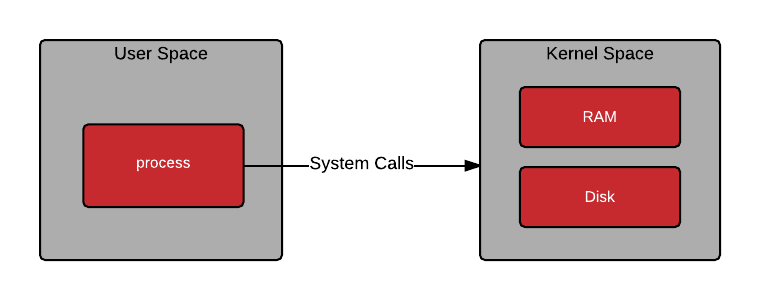

###Desenvolvimento de uma chamada de sistema

####Tabela de syscalls

A tabela de chamadas de sistema é um array de ponteiros de funções, que é acessado diretamente quando uma chamada de sistema ocorre. Cada chamada de sistema tem um índice na tabela e é selecionada pelo valor colocado em rax (numero da chamada de sistema).Na execução do código, o valor contido no registrador RAX é usado como um índice para a posição deste vetor que contém o endereço da rotina (chamada de sistema) que deverá ser executada.Para adicionar novas chamadas de sistemas precisamos modificar essa tabela que se utiliza de arquivos .tbl localizdas no diretório /arch/x86/entry/syscalls/ .




In [ ]:

# 64-bit system call numbers and entry vectors
#
# The format is:
# <number> <abi> <name> <entry point>
#
# The __x64_sys_*() stubs are created on-the-fly for sys_*() system calls
#
# The abi is "common", "64" or "x32" for this file.
#
0	common	read			sys_read
1	common	write			sys_write
2	common	open			sys_open
3	common	close			sys_close
4	common	stat			sys_newstat

# ...
546	x32	preadv2			compat_sys_preadv64v2
547	x32	pwritev2		compat_sys_pwritev64v2
# This is the end of the legacy x32 range.  Numbers 548 and above are
# not special and are not to be used for x32-specific syscalls.


#STAT




### Para que serve :

-> Retorna atributos de um arquivo sobre seus inodes .

**Relembrando :** O inode é apenas um índice de referência para um bloco de dados (unidade) que contém atributos e a localização do bloco de disco do objeto de dados. Pode incluir informações de metadados, como (horários da última alteração, acesso, modificação), bem como dados do proprietário e da permissão.

In [ ]:
!man stat

STAT(2)                    Linux Programmer's Manual                   STAT(2)

NNAAMMEE
       stat, fstat, lstat, fstatat - get file status

SSYYNNOOPPSSIISS
       ##iinncclluuddee <<ssyyss//ttyyppeess..hh>>
       ##iinncclluuddee <<ssyyss//ssttaatt..hh>>
       ##iinncclluuddee <<uunniissttdd..hh>>

       iinntt ssttaatt((ccoonnsstt cchhaarr **_p_a_t_h_n_a_m_e,, ssttrruucctt ssttaatt **_s_t_a_t_b_u_f));;
       iinntt ffssttaatt((iinntt _f_d,, ssttrruucctt ssttaatt **_s_t_a_t_b_u_f));;
       iinntt llssttaatt((ccoonnsstt cchhaarr **_p_a_t_h_n_a_m_e,, ssttrruucctt ssttaatt **_s_t_a_t_b_u_f));;

       ##iinncclluuddee <<ffccnnttll..hh>>           /* Definition of AT_* constants */
       ##iinncclluuddee <<ssyyss//ssttaatt..hh>>

       iinntt

Lembrando que ao realizar uma nova chamada , o gerenciador de chamadas dos sitema deve :

->Salvar o contexto

->Gerenciar a chamada do sistema requisitando a função em C , corresponde à rotina requerida

->Sair do gerenciador restaurando o contexto e retornando a CPU para o user space

Roteiro 

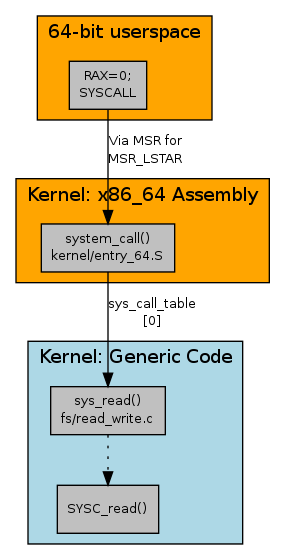

Fazendo a chamada da system call table que é representada como sys_call_table , podemos ver que a sys_call_table é um array de tamanho __NR_syscall_max + 1 .

In [ ]:
asmlinkage const sys_call_ptr_t sys_call_table[__NR_syscall_max+1] = {
    [0 ... __NR_syscall_max] = &sys_ni_syscall,
    #include <asm/syscalls_64.h>
};

curiosidade: asmlinkage significa que a função deve esperar seus argumentos na pilha em vez de nos registradores

fonte : arch/x86/entry/syscall_64.c

Para arquitetura x86_64 tem dois importantes tópicos:

1 - o tipo da sys_call_table 

2 - e como vai se dar a inicialização de seus elementos

.Para responder a primeira questão , observa-se que o typedef vai definir qual vai o tipo dela .


In [ ]:
typedef void (*sys_call_ptr_t)(void);

.Para a segunda questão , tem-se que analisar a inicialização da sys_call_table que estará no script em arch/x86/entry/syscall/syscalltbl.sh

In [ ]:
#define __SYSCALL_COMMON(nr, sym, compat) __SYSCALL_64(nr, sym, compat)
#define __SYSCALL_64(nr, sym, compat) [nr] = sym,

In [ ]:

__SYSCALL_COMMON(4, sys_newstat, sys_newstat)

Forma que a sys_call_table vai tomar

In [ ]:
asmlinkage const sys_call_ptr_t sys_call_table[__NR_syscall_max+1] = {
    [0 ... __NR_syscall_max] = &sys_ni_syscall,
    [0] = sys_read,
    [1] = sys_write,
    [2] = sys_open,
    [3] = sys_close
    [4] = sys_newstat
    ...
};

Neste ponto, **preenchemos** a tabela de chamadas do sistema e o **kernel Linux sabe onde cada manipulador de chamadas do sistema está**. **Mas** o kernel Linux não chama uma função sys_syscall_name
imediatamente após ser instruído a lidar com uma chamada do sistema a partir de uma aplicação do user space.Para isso vamos ter que fazer um **entry point** do sistema operacional.

O atributo importante aqui será o entry_point da system_call , que será 
acessado corretamente ao pegar o registrador RAX.

####System call entry 

Quando uma system call é invocada , ela é executada no anel de privilégio 0 .

Vamos abordar um pouco de hardware observando a arquitetura intel IA32_LSTAR .

Vai ter a inicialização da função cpu_init que vai carrregar o estado do cpu e também inicializar a função syscall_init (os scripts dessas funções podem ser visualizados em arch/x86/kernel/cpu/common.c) . A syscall_init vai permitir a inicialização do entry point da syscall .

In [ ]:
void syscall_init(void)
{
	wrmsr(MSR_STAR, 0, (__USER32_CS << 16) | __KERNEL_CS);
	wrmsrl(MSR_LSTAR, (unsigned long)entry_SYSCALL_64);

#ifdef CONFIG_IA32_EMULATION
	wrmsrl_cstar((unsigned long)entry_SYSCALL_compat);
	/*
	 * This only works on Intel CPUs.
	 * On AMD CPUs these MSRs are 32-bit, CPU truncates MSR_IA32_SYSENTER_EIP.
	 * This does not cause SYSENTER to jump to the wrong location, because
	 * AMD doesn't allow SYSENTER in long mode (either 32- or 64-bit).
	 */
	wrmsrl_safe(MSR_IA32_SYSENTER_CS, (u64)__KERNEL_CS);
	wrmsrl_safe(MSR_IA32_SYSENTER_ESP,
		    (unsigned long)(cpu_entry_stack(smp_processor_id()) + 1));
	wrmsrl_safe(MSR_IA32_SYSENTER_EIP, (u64)entry_SYSENTER_compat);
#else
	wrmsrl_cstar((unsigned long)ignore_sysret);
	wrmsrl_safe(MSR_IA32_SYSENTER_CS, (u64)GDT_ENTRY_INVALID_SEG);
	wrmsrl_safe(MSR_IA32_SYSENTER_ESP, 0ULL);
	wrmsrl_safe(MSR_IA32_SYSENTER_EIP, 0ULL);
#endif

	/*
	 * Flags to clear on syscall; clear as much as possible
	 * to minimize user space-kernel interference.
	 */
	wrmsrl(MSR_SYSCALL_MASK,
	       X86_EFLAGS_CF|X86_EFLAGS_PF|X86_EFLAGS_AF|
	       X86_EFLAGS_ZF|X86_EFLAGS_SF|X86_EFLAGS_TF|
	       X86_EFLAGS_IF|X86_EFLAGS_DF|X86_EFLAGS_OF|
	       X86_EFLAGS_IOPL|X86_EFLAGS_NT|X86_EFLAGS_RF|
	       X86_EFLAGS_AC|X86_EFLAGS_ID);
}


In [ ]:
#Dando ênfase para o mais importante : 
wrmsrl(MSR_LSTAR, entry_SYSCALL_64);

A instrução wrmsrl grava um valor em um registro específico do modelo, neste caso, o endereço da função geral de tratamento syscall system_call é escrito no registro MSR_LSTAR (0xc0000082), que é o registro específico do modelo x86_64 para lidar com a instrução SYSCALL . Dessa forma , nós setamos o entry point .

In [ ]:
#Para exemplificar (/arch/x86/entry/entry64.S)
SYM_CODE_START(entry_SYSCALL_64)
	UNWIND_HINT_ENTRY
	ENDBR

	swapgs
	/* tss.sp2 is scratch space. */
	movq	%rsp, PER_CPU_VAR(cpu_tss_rw + TSS_sp2)
	SWITCH_TO_KERNEL_CR3 scratch_reg=%rsp
	movq	PER_CPU_VAR(cpu_current_top_of_stack), %rsp

Vai ter ajustes nos registradores tais como MSR_IA32_SYSENTER_CS, MSR_IA32_SYSENTER_ESP, MSR_IA32_SYSENTER_EIP e também em algumas flags que não convém aprofundar nas especificidades .

Esse é o fim da função syscall_init e isso significa que a entrada de chamada do sistema está pronta para funcionar . A interface padrão para como os programas de usuário x86_64 invocam uma chamada de sistema é colocar o número de chamada do sistema (4 para stat() ) no registro RAX e os outros parâmetros em registros específicos (RDI, RSI, RDX para os primeiros 3 parâmetros), então emite a instrução SYSCALL .

#### Preparação antes de invocar a chamada de sistema 

Vamos ter que configurar alguns macros para ajustar alguns registradores e flags para que assim possamos chamar a chamada de sistema .


A entry_SYSCALL_64 é definida em arch/x86/entry/entry_64.S que nesse arquivo vai começar com o macro : 

In [ ]:
SWAPGS_UNSAFE_STACK

Que vai estar definido em arch/x86/include/asm/irqflags.h 

In [ ]:
#define SWAPGS_UNSAFE_STACK    swapgs

Vai ter alguns movq e pushq nesse arquivo assembly para tratar questões do cpu tal como : 

In [ ]:
movq    %rsp, PER_CPU_VAR(rsp_scratch)
movq    PER_CPU_VAR(cpu_current_top_of_stack), %rsp

pushq    $__USER_DS
pushq    PER_CPU_VAR(rsp_scratch)

Quando uma system call ocorre decorrente de uma aplicação do usuário , em propóstios gerais os estados dos registradores seguirá da seguinte forma 

rax - contains system call number;

rcx - contains return address to the user space;

r11 - contains register flags;

rdi - contains first argument of a system call handler;

rsi - contains second argument of a system call handler;

rdx - contains third argument of a system call handler;

r10 - contains fourth argument of a system call handler;

r8 - contains fifth argument of a system call handler;

r9 - contains sixth argument of a system call handler;


In [ ]:
movq    %r10, %rcx
call    *sys_call_table(, %rax, 8)

 Nós usamos *sys_call_table(,%rax,8) , pois a system call table vai ter 8 bytes . Finalmente após isso poderá ser chamada a system call . Basta dar o "comando" sys_newstat() . 

 E vamos ver o que acontece .

### /fs/stat.c

In [ ]:
// SPDX-License-Identifier: GPL-2.0
/*
 *  linux/fs/stat.c
 *
 *  Copyright (C) 1991, 1992  Linus Torvalds
 */
 /**
 # ...
 * generic_fillattr - Fill in the basic attributes from the inode struct
 * @inode: Inode to use as the source
 * @stat: Where to fill in the attributes
 *
 * Fill in the basic attributes in the kstat structure from data that's to be
 * found on the VFS inode structure.  This is the default if no getattr inode
 * operation is supplied.
 */
void generic_fillattr(struct inode *inode, struct kstat *stat)
{
	stat->dev = inode->i_sb->s_dev;
	stat->ino = inode->i_ino;
	stat->mode = inode->i_mode;
	stat->nlink = inode->i_nlink;
	stat->uid = inode->i_uid;
	stat->gid = inode->i_gid;
	stat->rdev = inode->i_rdev;
	stat->size = i_size_read(inode);
	stat->atime = inode->i_atime;
	stat->mtime = inode->i_mtime;
	stat->ctime = inode->i_ctime;
	stat->blksize = i_blocksize(inode);
	stat->blocks = inode->i_blocks;
}
EXPORT_SYMBOL(generic_fillattr);

Para entender melhor esse código precisamos estudar quais são as structs **inode** e **stat** 

In [ ]:
#Estrutura do inode no arquivo /fs/ext4/ext4.h
/*
 * Structure of an inode on the disk
 */
struct ext4_inode {
    __le16    i_mode;        /* File mode */
    __le16    i_uid;        /* Low 16 bits of Owner Uid */
    __le32    i_size_lo;    /* Size in bytes */
    __le32    i_atime;    /* Access time */
    __le32    i_ctime;    /* Inode Change time */
    __le32    i_mtime;    /* Modification time */
    __le32    i_dtime;    /* Deletion Time */
    __le16    i_gid;        /* Low 16 bits of Group Id */
    __le16    i_links_count;    /* Links count */
    __le32    i_blocks_lo;    /* Blocks count */
    __le32    i_flags;    /* File flags */
    union {
        struct {
            __le32  l_i_version;
        } linux1;
        struct {
            __u32  h_i_translator;
        } hurd1;
        struct {
            __u32  m_i_reserved1;
        } masix1;
    } osd1;                /* OS dependent 1 */
    __le32    i_block[EXT4_N_BLOCKS];/* Pointers to blocks */
    __le32    i_generation;    /* File version (for NFS) */
    __le32    i_file_acl_lo;    /* File ACL */
    __le32    i_size_high;
    __le32    i_obso_faddr;    /* Obsoleted fragment address */
    union {
        struct {
            __le16    l_i_blocks_high; /* were l_i_reserved1 */
            __le16    l_i_file_acl_high;
            __le16    l_i_uid_high;    /* these 2 fields */
            __le16    l_i_gid_high;    /* were reserved2[0] */
            __le16    l_i_checksum_lo;/* crc32c(uuid+inum+inode) LE */
            __le16    l_i_reserved;
        } linux2;processamento e visualização de dados
        struct {
            __le16    h_i_reserved1;    /* Obsoleted fragment number/size which are removed in ext4 */
            __u16    h_i_mode_high;
            __u16    h_i_uid_high;
            __u16    h_i_gid_high;
            __u32    h_i_author;
        } hurd2;
        struct {
            __le16    h_i_reserved1;    /* Obsoleted fragment number/size which are removed in ext4 */
            __le16    m_i_file_acl_high;
            __u32    m_i_reserved2[2];
        } masix2;
    } osd2;                /* OS dependent 2 */
    __le16    i_extra_isize;
    __le16    i_checksum_hi;    /* crc32c(uuid+inum+inode) BE */
    __le32  i_ctime_extra;  /* extra Change time      (nsec << 2 | epoch) */
    __le32  i_mtime_extra;  /* extra Modification time(nsec << 2 | epoch) */
    __le32  i_atime_extra;  /* extra Access time      (nsec << 2 | epoch) */
    __le32  i_crtime;       /* File Creation time */
    __le32  i_crtime_extra; /* extra FileCreationtime (nsec << 2 | epoch) */
    __le32  i_version_hi;    /* high 32 bits for 64-bit version */
    __le32    i_projid;    /* Project ID */
};

In [ ]:
## Estrutura do stat presente no comando man stat
           struct stat {
               dev_t     st_dev;         /* ID of device containing file */
               ino_t     st_ino;         /* Inode number */
               mode_t    st_mode;        /* File type and mode */
               nlink_t   st_nlink;       /* Number of hard links */
               uid_t     st_uid;         /* User ID of owner */
               gid_t     st_gid;         /* Group ID of owner */
               dev_t     st_rdev;        /* Device ID (if special file) */
               off_t     st_size;        /* Total size, in bytes */
               blksize_t st_blksize;     /* Block size for filesystem I/O */
               blkcnt_t  st_blocks;      /* Number of 512B blocks allocated */

               /* Since Linux 2.6, the kernel supports nanosecond
                  precision for the following timestamp fields.
                  For the details before Linux 2.6, see NOTES. */

               struct timespec st_atim;  /* Time of last access */
               struct timespec st_mtim;  /* Time of last modification */
               struct timespec st_ctim;  /* Time of last status change */

           #define st_atime st_atim.tv_sec      /* Backward compatibility */
           #define st_mtime st_mtim.tv_sec
           #define st_ctime st_ctim.tv_sec
           };

Tabela para entender melhor as variáveis 

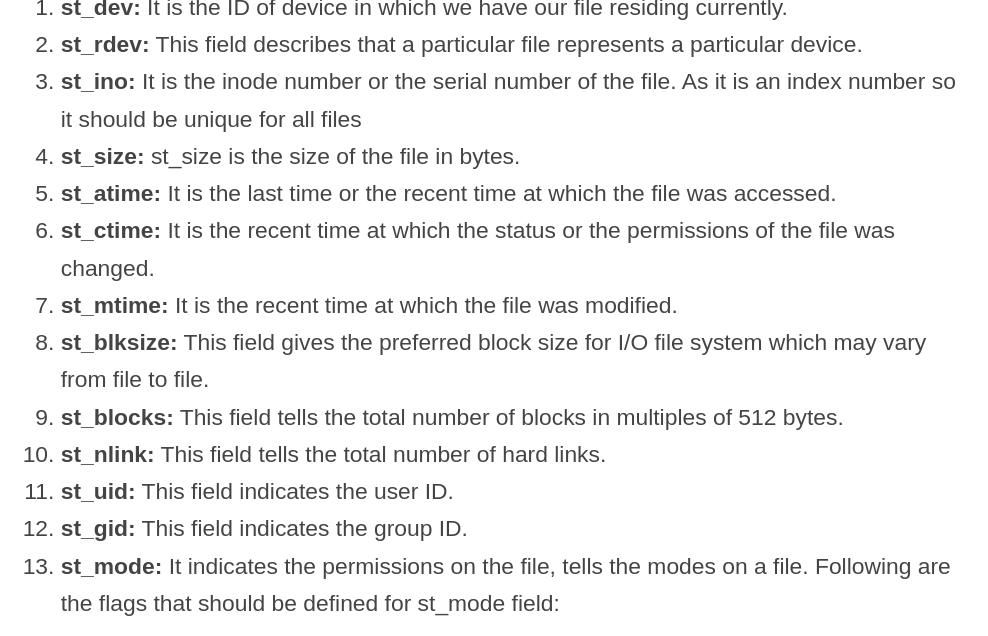

Tabela de flags e sua descrição 

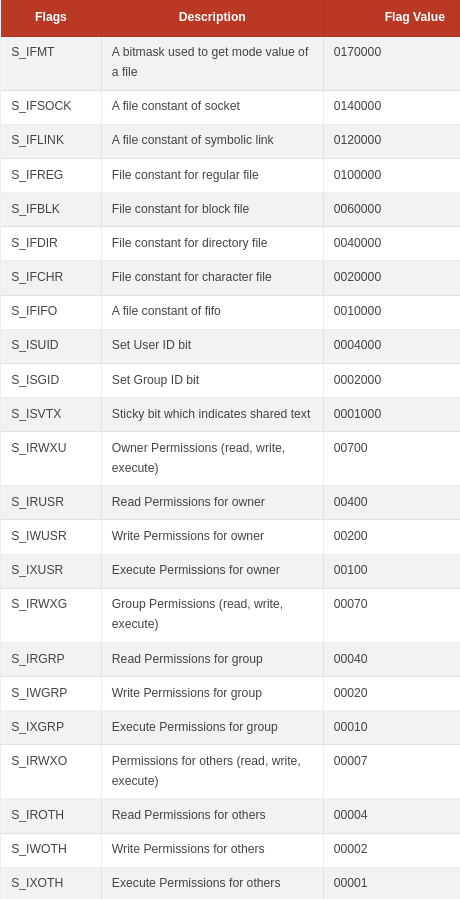

Um padrão mais antigo

In [ ]:
/*
 * For backward compatibility?  Maybe this should be moved
 * into arch/i386 instead?
 */
static int cp_old_stat(struct kstat *stat, struct __old_kernel_stat __user * statbuf)
{
	static int warncount = 5;
	struct __old_kernel_stat tmp;

	if (warncount > 0) {
		warncount--;
		printk(KERN_WARNING "VFS: Warning: %s using old stat() call. Recompile your binary.\n",
			current->comm);
	} else if (warncount < 0) {
		/* it's laughable, but... */
		warncount = 0;
	}

	memset(&tmp, 0, sizeof(struct __old_kernel_stat));
	tmp.st_dev = old_encode_dev(stat->dev);
	tmp.st_ino = stat->ino;
	if (sizeof(tmp.st_ino) < sizeof(stat->ino) && tmp.st_ino != stat->ino)
		return -EOVERFLOW;
	tmp.st_mode = stat->mode;
	tmp.st_nlink = stat->nlink;
	if (tmp.st_nlink != stat->nlink)
		return -EOVERFLOW;
	SET_UID(tmp.st_uid, from_kuid_munged(current_user_ns(), stat->uid));
	SET_GID(tmp.st_gid, from_kgid_munged(current_user_ns(), stat->gid));
	tmp.st_rdev = old_encode_dev(stat->rdev);
#if BITS_PER_LONG == 32
	if (stat->size > MAX_NON_LFS)
		return -EOVERFLOW;
#endif
	tmp.st_size = stat->size;
	tmp.st_atime = stat->atime.tv_sec;
	tmp.st_mtime = stat->mtime.tv_sec;
	tmp.st_ctime = stat->ctime.tv_sec;
	return copy_to_user(statbuf,&tmp,sizeof(tmp)) ? -EFAULT : 0;
}

Definindo a syscall stat

In [ ]:
SYSCALL_DEFINE2(stat, const char __user *, filename,
		struct __old_kernel_stat __user *, statbuf)
{
	struct kstat stat;
	int error;

	error = vfs_stat(filename, &stat);
	if (error)
		return error;

	return cp_old_stat(&stat, statbuf);
}

In [ ]:
#definido em include/linux/fs
static inline int vfs_stat(const char __user *filename, struct kstat *stat)
{
	return vfs_fstatat(AT_FDCWD, filename, stat, 0);
}

In [ ]:
int vfs_fstatat(int dfd, const char __user *filename, struct kstat *stat,
		int flags);

In [ ]:
#Aqui é a definição dele no fs
int vfs_fstatat(int dfd, const char __user *filename,
			      struct kstat *stat, int flags)
{
	int ret;
	int statx_flags = flags | AT_NO_AUTOMOUNT;
	struct filename *name;

	name = getname_flags(filename, getname_statx_lookup_flags(statx_flags), NULL);
	ret = vfs_statx(dfd, name, statx_flags, stat, STATX_BASIC_STATS);
	putname(name);

	return ret;
}

Um padrão mais novo 

In [ ]:
static int cp_new_stat(struct kstat *stat, struct stat __user *statbuf)
{
	struct stat tmp;

	if (!valid_dev(stat->dev) || !valid_dev(stat->rdev))
		return -EOVERFLOW;
#if BITS_PER_LONG == 32
	if (stat->size > MAX_NON_LFS)
		return -EOVERFLOW;
#endif

	INIT_STRUCT_STAT_PADDING(tmp);
	tmp.st_dev = encode_dev(stat->dev);
	tmp.st_ino = stat->ino;
	if (sizeof(tmp.st_ino) < sizeof(stat->ino) && tmp.st_ino != stat->ino)
		return -EOVERFLOW;
	tmp.st_mode = stat->mode;
	tmp.st_nlink = stat->nlink;
	if (tmp.st_nlink != stat->nlink)
		return -EOVERFLOW;
	SET_UID(tmp.st_uid, from_kuid_munged(current_user_ns(), stat->uid));
	SET_GID(tmp.st_gid, from_kgid_munged(current_user_ns(), stat->gid));
	tmp.st_rdev = encode_dev(stat->rdev);
	tmp.st_size = stat->size;
	tmp.st_atime = stat->atime.tv_sec;
	tmp.st_mtime = stat->mtime.tv_sec;
	tmp.st_ctime = stat->ctime.tv_sec;
#ifdef STAT_HAVE_NSEC
	tmp.st_atime_nsec = stat->atime.tv_nsec;
	tmp.st_mtime_nsec = stat->mtime.tv_nsec;
	tmp.st_ctime_nsec = stat->ctime.tv_nsec;
#endif
	tmp.st_blocks = stat->blocks;
	tmp.st_blksize = stat->blksize;
	return copy_to_user(statbuf,&tmp,sizeof(tmp)) ? -EFAULT : 0;
}

Definindo a newstat

In [ ]:
SYSCALL_DEFINE2(newstat, const char __user *, filename,
		struct stat __user *, statbuf)
{
	struct kstat stat;
	int error = vfs_stat(filename, &stat);

	if (error)
		return error;
	return cp_new_stat(&stat, statbuf);
}

In [ ]:
#Inode Operations include/linux/fs.h 
struct inode_operations {
	struct dentry * (*lookup) (struct inode *,struct dentry *, unsigned int);
	const char * (*get_link) (struct dentry *, struct inode *, struct delayed_call *);
	int (*permission) (struct user_namespace *, struct inode *, int);
	struct posix_acl * (*get_acl)(struct inode *, int, bool);

	int (*readlink) (struct dentry *, char __user *,int);

	int (*create) (struct user_namespace *, struct inode *,struct dentry *,
		       umode_t, bool);
	int (*link) (struct dentry *,struct inode *,struct dentry *);
	int (*unlink) (struct inode *,struct dentry *);
	int (*symlink) (struct user_namespace *, struct inode *,struct dentry *,
			const char *);
	int (*mkdir) (struct user_namespace *, struct inode *,struct dentry *,
		      umode_t);
	int (*rmdir) (struct inode *,struct dentry *);
	int (*mknod) (struct user_namespace *, struct inode *,struct dentry *,
		      umode_t,dev_t);
	int (*rename) (struct user_namespace *, struct inode *, struct dentry *,
			struct inode *, struct dentry *, unsigned int);
	int (*setattr) (struct user_namespace *, struct dentry *,
			struct iattr *);
	int (*getattr) (struct user_namespace *, const struct path *,
			struct kstat *, u32, unsigned int);
	ssize_t (*listxattr) (struct dentry *, char *, size_t);
	int (*fiemap)(struct inode *, struct fiemap_extent_info *, u64 start,
		      u64 len);
	int (*update_time)(struct inode *, struct timespec64 *, int);
	int (*atomic_open)(struct inode *, struct dentry *,
			   struct file *, unsigned open_flag,
			   umode_t create_mode);
	int (*tmpfile) (struct user_namespace *, struct inode *,
			struct dentry *, umode_t);
	int (*set_acl)(struct user_namespace *, struct inode *,
		       struct posix_acl *, int);
	int (*fileattr_set)(struct user_namespace *mnt_userns,
			    struct dentry *dentry, struct fileattr *fa);
	int (*fileattr_get)(struct dentry *dentry, struct fileattr *fa);
} ____cacheline_aligned;

### Exemplos práticos do uso da chamada STAT

1 - Encontrando o mode do arquivo


In [ ]:
#include<stdio.h>
#include<sys/stat.h>
int main()
{
  //pointer to stat struct
  struct stat sfile;

  //stat system call
  stat("stat.c", &sfile);

  //accessing st_mode (data member of stat struct)  
  printf("st_mode = %o", sfile.st_mode);
  return 0;
}

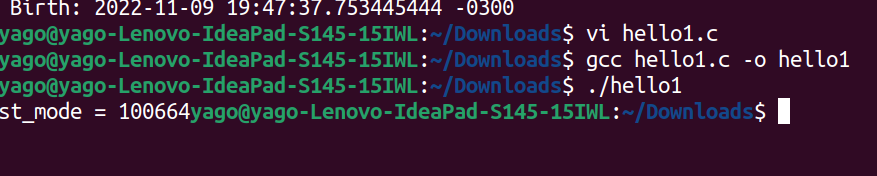

2 - Pegando informação sobre o arquivo

In [ ]:
#include<stdio.h>
#include<sys/stat.h>
#include<fcntl.h>
#include<stdlib.h>

void sfile(char const filename[]);

int main(){
  ssize_t read;
  char* buffer = 0;
  size_t buf_size = 0;

  printf("Enter the name of a file to check: \n");
  read = getline(&buffer, &buf_size, stdin);

  if (read <=0 ){
    printf("getline failed\n");
    exit(1);
  }

  if (buffer[read-1] == '\n'){
    buffer[read-1] = 0;
  }

  int s=open(buffer,O_RDONLY);
  if(s==-1){
    printf("File doesn't exist\n");
    exit(1);
  }
  else{
    sfile(buffer);
  }
  free(buffer);
  return 0;
}

void sfile(char const filename[]){

  struct stat sfile;

  if(stat(filename,&sfile)==-1){
    printf("Error Occurred\n");
  }

  //Accessing data members of stat struct
  printf("\nFile st_uid %d \n",sfile.st_uid);
  printf("\nFile st_blksize %ld \n",sfile.st_blksize);
  printf("\nFile st_gid %d \n",sfile.st_gid);
  printf("\nFile st_blocks %ld \n",sfile.st_blocks);
  printf("\nFile st_size %ld \n",sfile.st_size);
  printf("\nFile st_nlink %u \n",(unsigned int)sfile.st_nlink);
  printf("\nFile Permissions User\n");
  printf((sfile.st_mode & S_IRUSR)? "r":"-");
  printf((sfile.st_mode & S_IWUSR)? "w":"-");
  printf((sfile.st_mode & S_IXUSR)? "x":"-");
  printf("\n");
  printf("\nFile Permissions Group\n");
  printf((sfile.st_mode & S_IRGRP)? "r":"-");
  printf((sfile.st_mode & S_IWGRP)? "w":"-");
  printf((sfile.st_mode & S_IXGRP)? "x":"-");
  printf("\n");
  printf("\nFile Permissions Other\n");
  printf((sfile.st_mode & S_IROTH)? "r":"-");
  printf((sfile.st_mode & S_IWOTH)? "w":"-");
  printf((sfile.st_mode & S_IXOTH)? "x":"-");
  printf("\n");
}

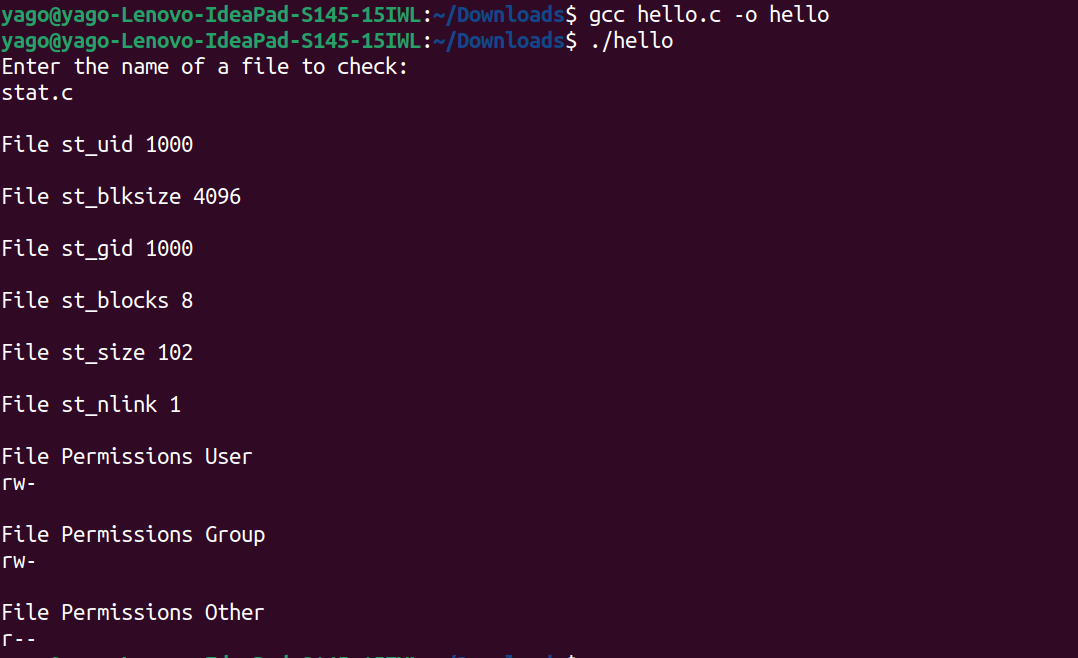

## Referências 

https://0xax.gitbooks.io/linux-insides/content/SysCall/linux-syscall-2.html

http://www2.comp.ufscar.br/mediawiki/index.php/GrupoSysCall_2013/1#Entrando_e_saindo_da_Chamada

http://www2.comp.ufscar.br/mediawiki/index.php/GrupoSysCall_2020/2_ENPE#invoca.C3.A7.C3.A3o_syscall_x86_64

https://elixir.bootlin.com/linux/v5.10.5/source/arch

https://linux.die.net/man/2/stat

https://hackeradam.com/x86-64-linux-syscalls/

https://linuxhint.com/stat-system-call-linux/